In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
dynamic_fc_full_analysis.py
──────────────────────────—
Pipeline from 4D fMRI (PA & AP) → dynamic‐FC → two‐way ANOVA on dwell times.
"""

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from joblib import Parallel, delayed

from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

from sklearn.cluster import KMeans

import statsmodels.api as sm
from statsmodels.formula.api import ols

# ─── 1. USER PARAMETERS ───────────────────────────────
BASE_DIR = "/data/s.dharia-ra/PEARL/PEARL/derivatives_selected"


N_JOBS   = 32         # for Parallel
WIN_LEN  = 20         # volumes (16 s)
STEP     = 5         # volumes (4 s)
TR       = 0.8        # seconds per volume
          # connectivity‐state count
LABEL_MAP= {0:"N", 1:"A+P-", 2:"A+P+"}
ATLAS_IMG = (
    "/home/s.dharia-ra/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_atlas-Schaefer2018_desc-100Parcels7Networks_dseg.nii.gz"
)
# ─── 2. GATHER BOTH PA & AP RUNS ───────────────────────
runs = []
for pat, tech in [
    (os.path.join(BASE_DIR, "sub-*/func/sub-*_task-rest_dir-PA*desc-preproc_bold.nii.gz"), "PA"),
    (os.path.join(BASE_DIR, "sub-*/func/sub-*_task-rest_dir-AP*desc-preproc_bold.nii.gz"), "AP"),
]:
    for fp in sorted(glob.glob(pat)):
        subj_dir = Path(fp).parent.parent
        sid = subj_dir.name.replace("sub-","")
        labf = subj_dir/"label.txt"
        if not labf.exists():
            raise FileNotFoundError(f"Missing label.txt for {sid}")
        lab = int(labf.read_text().strip())
        runs.append((fp, sid, LABEL_MAP[lab], tech))
print(f"Found {len(runs)} total runs ({len(runs)//2} subjects × 2 techniques)")

# ─── 3. ROI TIME‐SERIES EXTRACTION ────────────────────
masker = NiftiLabelsMasker(
    labels_img=ATLAS_IMG,
    standardize=True,
    detrend=True,
    t_r=TR
)
def load_ts(fp):
    return masker.fit_transform(fp)

print("Extracting ROI time-series for each run…")
ts_list = Parallel(n_jobs=N_JOBS)(
    delayed(load_ts)(fp) for fp,_,_,_ in runs
)

# ─── 4. SLIDING‐WINDOW FC ─────────────────────────────
conn = ConnectivityMeasure(kind="correlation", vectorize=True, discard_diagonal=True)
all_windows = []
sub_idx     = []
start = 0

print("Computing sliding‐window FC…")
for i, ts in enumerate(ts_list):
    n_vols = ts.shape[0]
    n_win  = 1 + (n_vols - WIN_LEN)//STEP
    mats   = []
    for w in range(n_win):
        sl = slice(w*STEP, w*STEP + WIN_LEN)
        conn_mat  = conn.fit_transform([ts[sl]])[0]
        mats.append(conn_mat)
    mats = np.vstack(mats)
    # Fisher Z
    # mats = np.arctanh(np.clip(mats, -0.9999, 0.9999))
    all_windows.append(mats)
    sub_idx.append((i, start, start + n_win))
    start += n_win

X = np.vstack(all_windows)  # shape = (total_windows, n_edges)



In [1]:
# np.savez_compressed(
#     "all_windows.npz",
#     X=X,
#     sub_idx=sub_idx,
#     runs=runs
# )

import numpy as np

data = np.load("all_windows.npz")
X = data['X']  # shape = (total_windows, n_edges)
sub_idx = data['sub_idx']  # list of (run_i, start, stop)
runs = data['runs']  # list of (fp, sid, label, tech)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1) Choose ggplot base, then override to white
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']   = 3
plt.rcParams['axes.facecolor']    = 'white'
plt.rcParams['figure.facecolor']  = 'white'
plt.rcParams['axes.edgecolor']    = 'black'
plt.rcParams['xtick.color']       = 'black'
plt.rcParams['ytick.color']       = 'black'
plt.rcParams['grid.color']        = 'gray'
plt.rcParams['grid.linestyle']    = '--'
plt.rcParams['grid.alpha']        = 0.5

# 2) Compute inertias as before
Ks = list(range(1, 16))
inertias = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=1, max_iter=10000)
    km.fit(X)
    inertias.append(km.inertia_)


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(Ks, inertias, marker='o',color='lightblue', label='Inertia')
ax.scatter(Ks, inertias, s=80, color='lightblue', zorder=3)
elbow_k = 3


ax.set_xlabel('Number of clusters $k$', fontsize=12, color='black')
ax.set_ylabel('Inertia (WCSS)', fontsize=12, color='black')
# ax.set_title('Elbow Method for Optimal $k$', fontsize=14, fontweight='bold', color='black')
ax.set_xticks(Ks)
ax.grid(True)

ax.legend(frameon=False, fontsize=10)
plt.savefig("elbow.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1) cluster in original space
k = 9
km = KMeans(n_clusters=k, n_init="auto", random_state=1, max_iter=100000)
labels = km.fit_predict(X)

# 2) reduce to 2D
pca = PCA(n_components=2, random_state=1)
X2 = pca.fit_transform(X)
centers2 = pca.transform(km.cluster_centers_)

# 3) set ggplot style
plt.style.use('ggplot')

# 4) plot
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(
    X2[:,0], X2[:,1],
    c=labels, cmap='tab10',
    s=60, alpha=0.8,
    edgecolor='k', linewidth=0.5
)

# plot and label centers
ax.scatter(centers2[:,0], centers2[:,1],
           marker='X', s=200, c='k')
for idx, (x, y) in enumerate(centers2):
    ax.text(
        x, y, str(idx),
        color='w', fontsize=16, fontweight='bold',
        ha='center', va='center',
        bbox=dict(facecolor='k', alpha=0.6, boxstyle='round,pad=0.2')
    )

# labels, title, grid
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
# ax.set_title(f'PCA Projection of K-Means (k={k})', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig(f'kmeans_pca_projection_k={k}.png', dpi=300, bbox_inches='tight')
fig.tight_layout()
plt.show()


Clustering into 7 states…
Built DataFrame with shape: (966, 5)

Two‐way ANOVA (genotype × technique) on dwell_time:

--- State 0 ---

--- State 0 ---
                                 sum_sq     df         F    PR(>F)
C(genotype)                13108.594288    2.0  5.691308  0.004257
C(technique)                 818.086957    1.0  0.710371  0.400845
C(genotype):C(technique)     803.744046    2.0  0.348958  0.706071
Residual                  152015.545724  132.0       NaN       NaN

--- State 1 ---

--- State 1 ---
                                 sum_sq     df         F    PR(>F)
C(genotype)                 6212.649886    2.0  1.869499  0.158261
C(technique)                 289.855072    1.0  0.174445  0.676870
C(genotype):C(technique)     592.420375    2.0  0.178270  0.836918
Residual                  219328.726841  132.0       NaN       NaN

--- State 2 ---

--- State 2 ---
                                 sum_sq     df         F    PR(>F)
C(genotype)                 6869.896093    2.

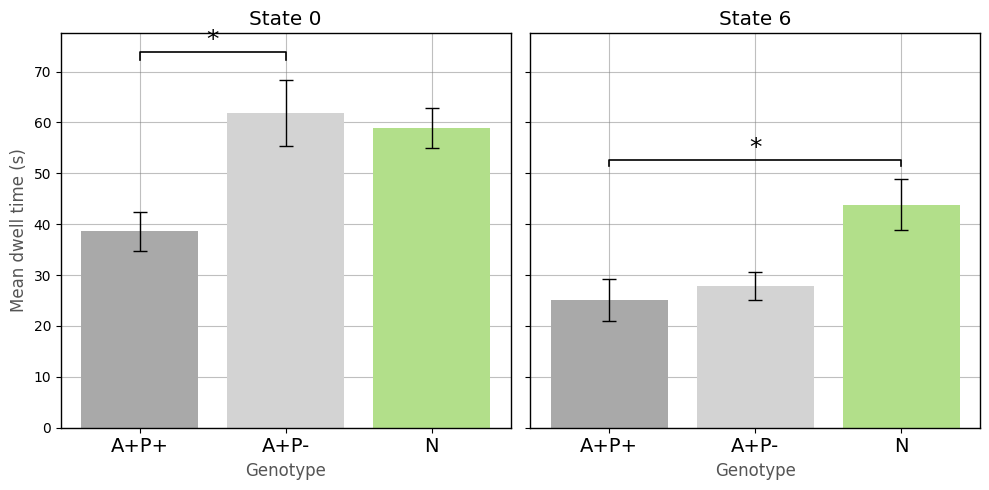

In [2]:
from sklearn.cluster import KMeans
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd
import itertools

# ─── 5. K‐MEANS CLUSTERING ────────────────────────────
K_STATES = 7
STEP     = 5         # volumes (4 s)
TR       = 0.8        # seconds per volume
print(f"Clustering into {K_STATES} states…")
kmeans = KMeans(n_clusters=K_STATES, n_init="auto", random_state=1, max_iter=100000)#algorithm="elkan"
win_labels = kmeans.fit_predict(X)



# ─── 6. METRIC EXTRACTION ─────────────────────────────
results = []
for i, (fp, sid, grp, tech) in enumerate(runs):
    _, s0, s1 = sub_idx[i]
    labs      = win_labels[s0:s1]
    counts    = np.bincount(labs, minlength=K_STATES)
    dwell     = counts * STEP * TR  # in seconds

    for st in range(K_STATES):
        results.append({
            "subj":       sid,
            "genotype":   grp,
            "technique":  tech,
            "state":      st,
            "dwell_time": float(dwell[st])
        })

df = pd.DataFrame(results)
print("Built DataFrame with shape:", df.shape)

# ─── 7. TWO‐WAY ANOVA PER STATE ──────────────────────
anova_p_any = {}
print("\nTwo‐way ANOVA (genotype × technique) on dwell_time:")
for st in range(K_STATES):
    print(f"\n--- State {st} ---")
    df_st = df[df.state == st]
    model = ols('dwell_time ~ C(genotype) * C(technique)', data=df_st).fit()
    aov   = sm.stats.anova_lm(model, typ=2)
    print(f"\n--- State {st} ---")
    print(aov)
    # record the smallest p-value across main/interaction effects
    anova_p_any[st] = aov['PR(>F)'].min()

# ─── 8. POST‐HOC TUKEY + FDR ─────────────────────────
# select states where any ANOVA term was significant
sig_states = [st for st,p in anova_p_any.items() if p < 0.05]
print("\nStates with any ANOVA p<0.05:", sig_states)

posthoc = []
for st in sig_states:
    df_st = df[df.state == st]

    # a) Genotype contrasts
    tuk_g = pairwise_tukeyhsd(
        endog  = df_st['dwell_time'],
        groups = df_st['genotype'],
        alpha  = 0.05
    )
    for row in tuk_g.summary().data[1:]:
        posthoc.append({
            'state':    st,
            'factor':   'genotype',
            'contrast': f"{row[0]} vs {row[1]}",
            'p_raw':    float(row[3])
        })

    # b) Technique contrasts
    tuk_t = pairwise_tukeyhsd(
        endog  = df_st['dwell_time'],
        groups = df_st['technique'],
        alpha  = 0.05
    )
    for row in tuk_t.summary().data[1:]:
        posthoc.append({
            'state':    st,
            'factor':   'technique',
            'contrast': f"{row[0]} vs {row[1]}",
            'p_raw':    float(row[3])
        })

    # c) Technique within each genotype
    for geno in df_st['genotype'].unique():
        df_sub = df_st[df_st['genotype'] == geno]
        if df_sub['technique'].nunique() > 1:
            tuk_i = pairwise_tukeyhsd(
                endog  = df_sub['dwell_time'],
                groups = df_sub['technique'],
                alpha  = 0.05
            )
            for row in tuk_i.summary().data[1:]:
                posthoc.append({
                    'state':    st,
                    'factor':   f"technique|{geno}",
                    'contrast': f"{row[0]} vs {row[1]}",
                    'p_raw':    float(row[3])
                })

# FDR‐correct all post-hoc p-values
p_raws = [r['p_raw'] for r in posthoc]
print("p_raws:", p_raws)
rej, p_adj, _, _ = multipletests(p_raws, alpha=0.05, method='fdr_bh')
for i, r in enumerate(posthoc):
    r['p_fdr']  = p_adj[i]
    r['signif'] = bool(rej[i])

df_post = pd.DataFrame(posthoc)
print("\nPost-hoc Tukey results (raw & FDR‐adjusted):")
print(df_post[['state','factor','contrast','p_raw','p_fdr','signif']])


import numpy as np
import matplotlib.pyplot as plt

# 1) ggplot look
plt.style.use('ggplot')

plt.style.use('ggplot')
plt.rcParams['lines.linewidth']   = 1
plt.rcParams['axes.facecolor']    = 'white'
plt.rcParams['figure.facecolor']  = 'white'
plt.rcParams['axes.edgecolor']    = 'black'
plt.rcParams['xtick.color']       = 'black'
plt.rcParams['ytick.color']       = 'black'
plt.rcParams['grid.color']        = 'gray'
plt.rcParams['grid.linestyle']    = '-'
plt.rcParams['grid.alpha']        = 0.5


# 2) normalize genotype labels to lowercase
df['genotype'] = df['genotype'].str.lower()
# also lowercase the contrasts
df_post['contrast'] = df_post['contrast'].str.lower()

# 3) pull genotype‐significant contrasts (FDR < 0.1)
geno_tests = df_post[
    (df_post.factor == 'genotype') &
    (df_post.p_fdr < 0.05)
]
states = sorted(geno_tests.state.unique())
if not states:
    print("No genotype contrasts with FDR < 0.1 to plot.")

# 4) colour map
# 4) pastel‐shade colour map
color_map = {
    'a+p+': '#A9A9A9',   # pastel “black” (light gray)
    'a+p-': '#D3D3D3',   # pastel “gray”
    'n':    '#B2DF8A'    # pastel green
}


# 5) star‐helper
def star_label(p):
    if p < 0.01: return '**'
    if p < 0.05: return '*'
    return ''

# 6) build figure
n = len(states)
fig, axes = plt.subplots(1, n, figsize=(5*n, 5), sharey=True)
if n == 1:
    axes = [axes]

for ax, st in zip(axes, states):
    df_st = df[df.state == st]

    # 7) summary stats
    all_groups = ['a+p+','a+p-','n']
    stats0 = (
        df_st
        .groupby('genotype')['dwell_time']
        .agg(['mean','sem'])
        .reset_index()
    )
    # keep only present genotypes, in fixed order
    present = [g for g in all_groups if g in stats0['genotype'].values]
    stats = (
        stats0
        .set_index('genotype')
        .loc[present]
        .reset_index()
    )

    genes = stats['genotype'].tolist()
    x     = np.arange(len(genes))
    means = stats['mean'].values
    sems  = stats['sem'].values
    cols  = [color_map[g] for g in genes]

    # 8) draw bars + error bars
    ax.bar(x, means, yerr=sems, capsize=5, color=cols)
    ax.set_xticks(x)
    ax.set_xticklabels(genes,fontsize=14)
    ax.set_title(f'State {st}')
    ax.set_xlabel('Genotype')
    if ax is axes[0]:
        ax.set_ylabel('Mean dwell time (s)')

    # 9) annotate brackets
    tests = geno_tests[geno_tests.state == st].sort_values('p_fdr')
    ymax   = (means + sems).max()
    offset = ymax * 0.08
    current = ymax + offset

    for _, row in tests.iterrows():
        g1, g2 = row.contrast.split(' vs ')
        # skip if one of the genotypes isn’t present
        if g1 not in genes or g2 not in genes:
            continue
        i1, i2 = genes.index(g1), genes.index(g2)
        x1, x2 = x[i1], x[i2]

        # bracket
        ax.plot(
            [x1, x1, x2, x2],
            [current-offset*0.3, current, current, current-offset*0.3],
            color='black', lw=1.2
        )
        # star
        ax.text(
            (x1 + x2)/2,
            current,
            star_label(row.p_fdr),
            ha='center', va='bottom',
            fontsize=18
        )
        current += offset  # stagger next
        ax.set_xticklabels([g.upper() for g in genes])


fig.tight_layout()
plt.savefig("genotype_dwell_times.png", dpi=300, bbox_inches='tight')
plt.show()





▶ State 0: contrasts = [('A+P+', 'A+P-')]
  → groups = ['A+P+', 'A+P-']

  ✔ dwell_times_state_0.csv
hub proportion: 100
  hub names: ['LH_Vis_2', 'LH_DorsAttn_Post_1', 'LH_Vis_1', 'LH_DorsAttn_FEF_2', 'RH_DorsAttn_Post_4', 'LH_Vis_3', 'LH_DorsAttn_Post_4', 'LH_SalVentAttn_ParOper_1', 'LH_DorsAttn_Post_3', 'LH_SalVentAttn_Med_2']
  hub proportion: [0.04 0.04 0.05 0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.03
 0.02 0.04 0.02 0.07 0.05 0.01 0.01 0.   0.04 0.05 0.03 0.   0.   0.01
 0.07 0.03 0.03 0.02 0.   0.   0.03 0.01 0.03 0.03 0.   0.01 0.01 0.
 0.02 0.02 0.01 0.   0.01 0.   0.   0.03 0.01 0.03 0.03 0.   0.   0.01
 0.   0.   0.02 0.   0.   0.01 0.01 0.01 0.   0.   0.01 0.02 0.02 0.04
 0.01 0.   0.02 0.02 0.02 0.02 0.01 0.   0.01 0.02 0.01 0.01 0.   0.
 0.   0.   0.   0.01 0.   0.   0.   0.02 0.   0.01 0.02 0.   0.   0.01
 0.   0.  ]
  top 10: [ 1 15  0 22 69  2 18 23 17 28]


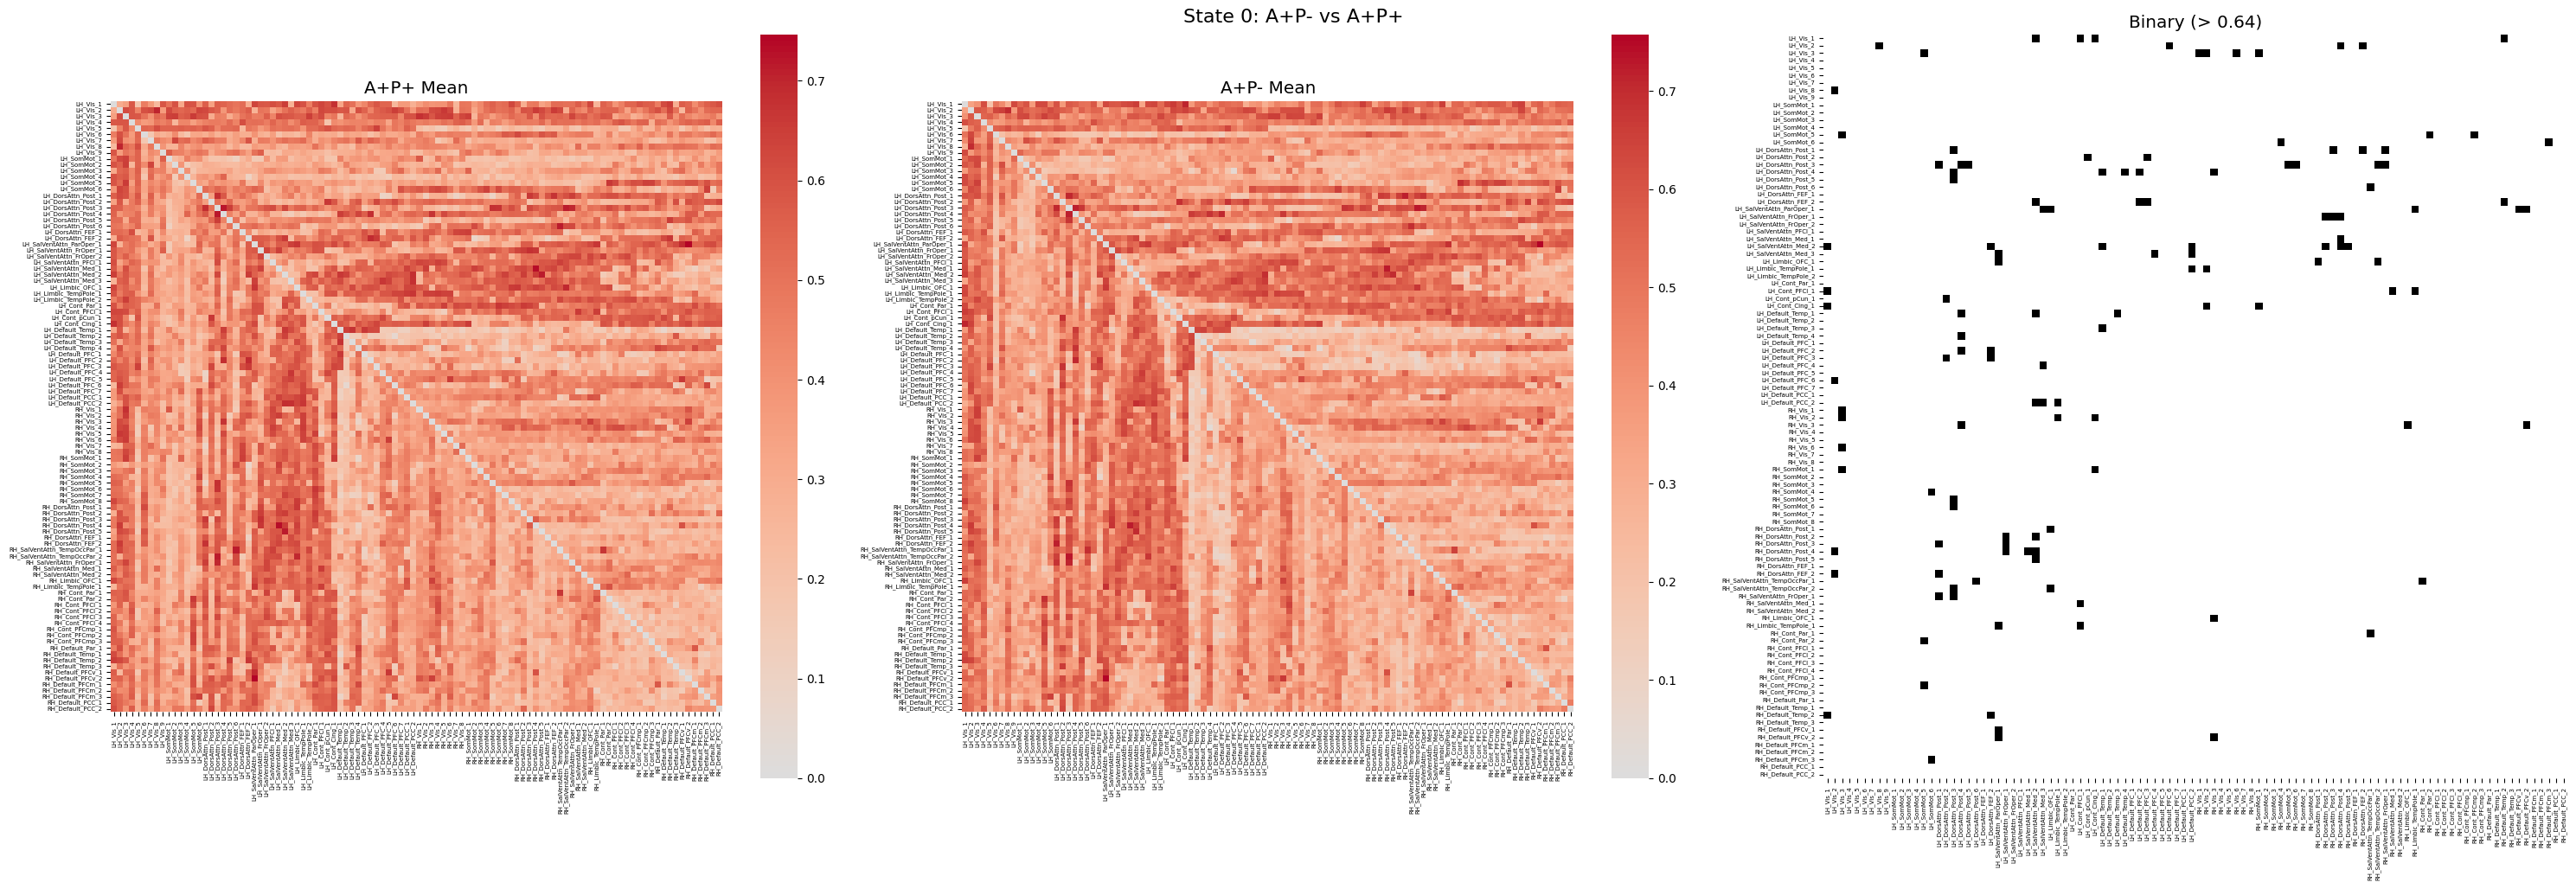

  ✔ state0_AplusP-_vs_AplusPplus.png


▶ State 6: contrasts = [('A+P+', 'N')]
  → groups = ['A+P+', 'N']

  ✔ dwell_times_state_6.csv
hub proportion: 100
  hub names: ['RH_SalVentAttn_TempOccPar_1', 'LH_Cont_PFCl_1', 'LH_Default_PFC_2', 'LH_SalVentAttn_Med_2', 'LH_SalVentAttn_Med_3', 'RH_SalVentAttn_TempOccPar_2', 'LH_Default_PCC_2', 'LH_Cont_Par_1', 'LH_Default_Temp_1', 'LH_DorsAttn_Post_3']
  hub proportion: [0.01 0.01 0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.
 0.   0.01 0.   0.05 0.02 0.01 0.01 0.   0.   0.01 0.   0.   0.   0.01
 0.02 0.02 0.01 0.01 0.01 0.03 0.02 0.   0.01 0.04 0.01 0.01 0.   0.01
 0.02 0.   0.01 0.01 0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.01
 0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.01 0.01 0.01
 0.01 0.   0.   0.02 0.02 0.01 0.01 0.   0.   0.01 0.01 0.   0.   0.
 0.   0.01 0.   0.   0.   0.   0.   0.01 0.   0.01 0.01 0.   0.   0.
 0.   0.  ]
  top 10: [73 34 42 28 29 74 49 33 37 17]


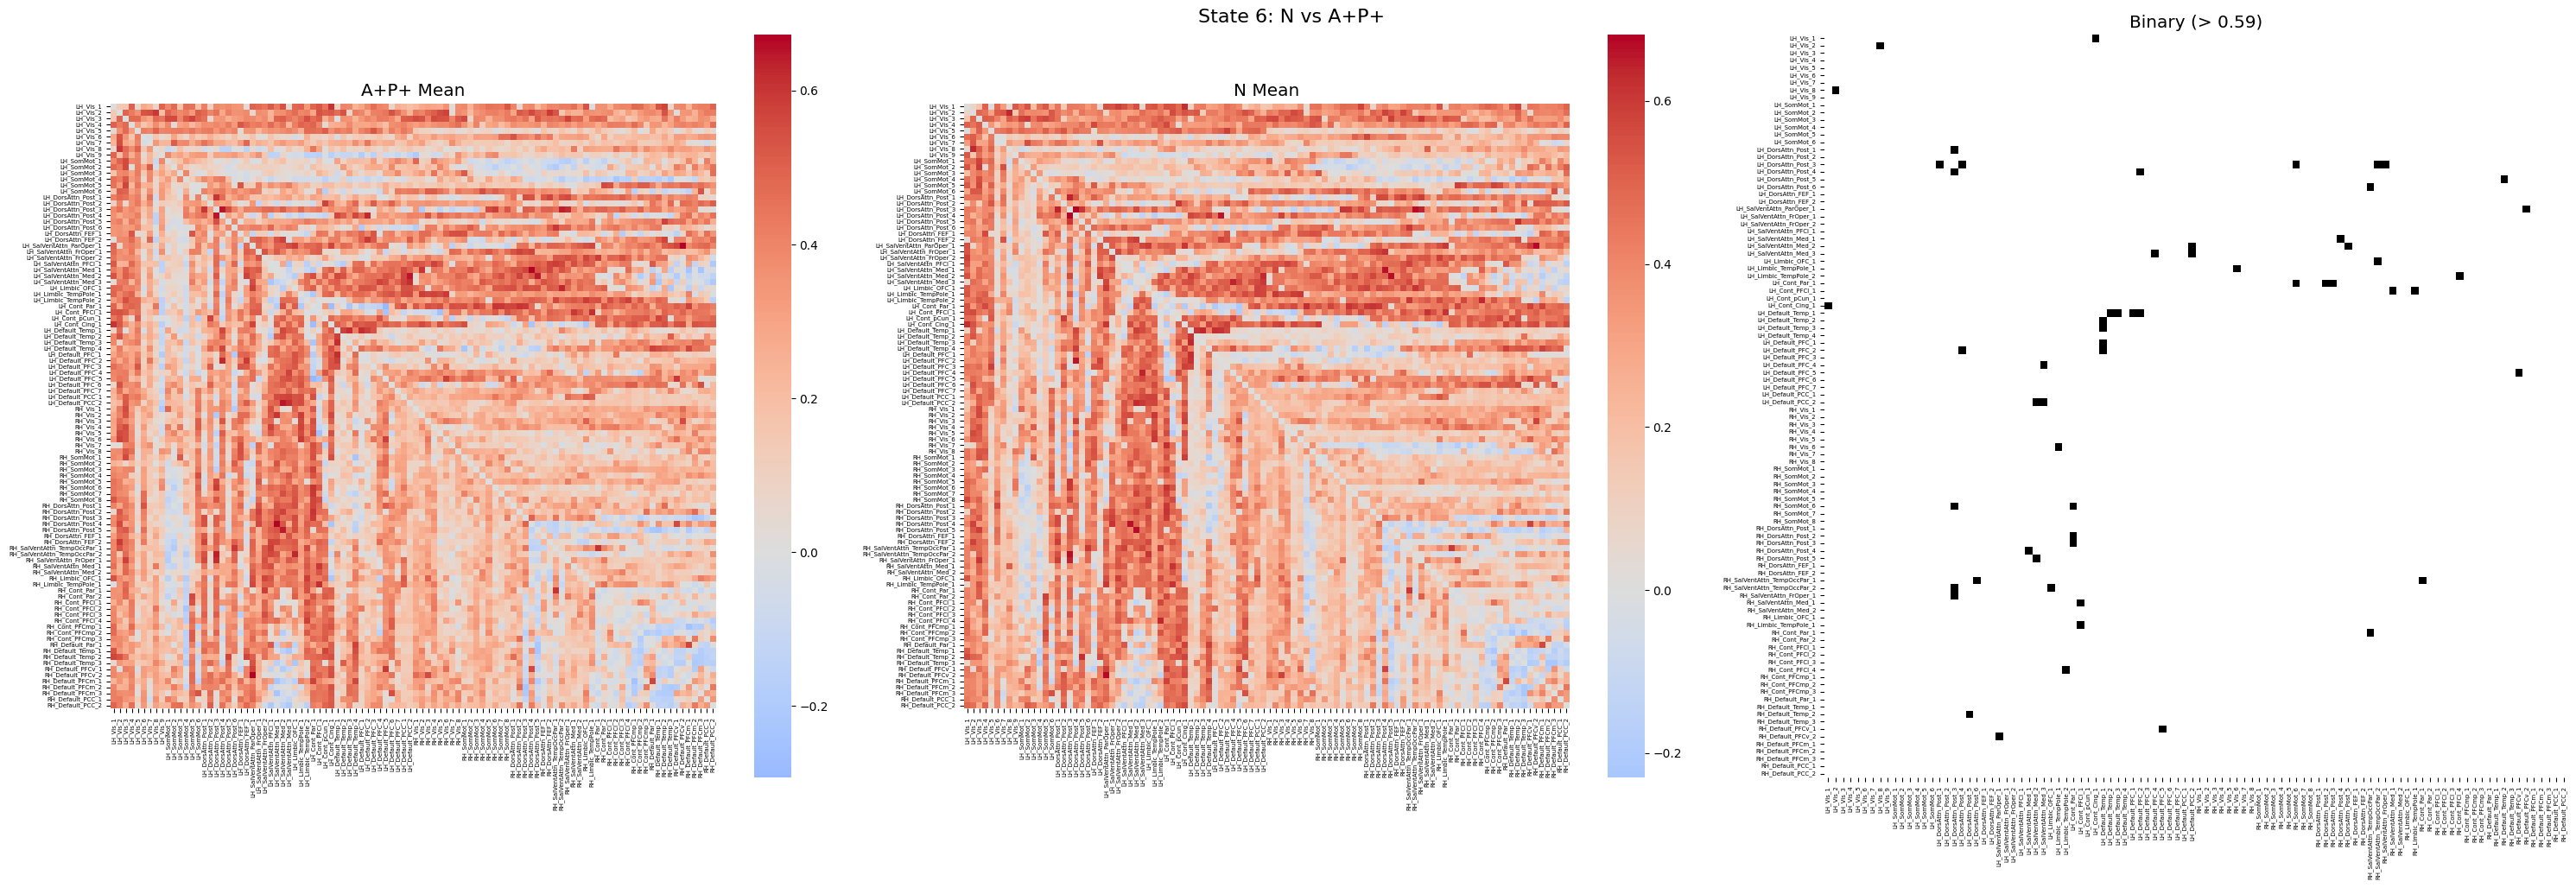

  ✔ state6_N_vs_AplusPplus.png



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd
import re
import templateflow.api as tf

def vec_to_symmat(vec):
    """Convert a vectorized upper-triangular vector to a full symmetric matrix."""
    n_elem = vec.shape[-1]
    size   = int((1 + np.sqrt(1 + 8 * n_elem)) / 2)
    mat    = np.zeros((size, size))
    iu     = np.triu_indices(size, k=1)
    mat[iu]             = vec
    mat[(iu[1], iu[0])] = vec
    return mat

def plot_group_matrix_diffs(
    X, win_labels, sub_idx, runs, df_post, names, group_col='genotype'
):
    sig_states = sorted(df_post[df_post['signif']]['state'].unique())

    for st in sig_states:
        # 1) get significant contrasts for this state
        sig_df = df_post[(df_post['state']==st) & (df_post['signif'])]
        # inside your for st in sig_states: block
        sig_pairs = []
        for contrast in sig_df['contrast']:
            if ' vs ' in contrast:
                g1, g2 = contrast.split(' vs ')
            elif ' - ' in contrast:
                g1, g2 = contrast.split(' - ')
            else:
                continue

            # normalize
            g1, g2 = g1.strip().upper(), g2.strip().upper()
            sig_pairs.append((g1, g2))


        if not sig_pairs:
            print(f"No valid contrasts for state {st}, skipping.")
            continue

        sig_groups = sorted({g for pair in sig_pairs for g in pair})
        print(f"\n▶ State {st}: contrasts = {sig_pairs}")
        print(f"  → groups = {sig_groups}\n")

        # 2) collect per-subject windows for sig_groups
        subject_counts   = defaultdict(int)
        subject_matrices = defaultdict(list)
        for i, (fp, sid, grp, tech) in enumerate(runs):
            key = grp if group_col=='genotype' else tech
            if key not in sig_groups:
                continue
            _, s0, s1 = sub_idx[i]
            labs      = win_labels[s0:s1]
            in_state  = (labs == st)
            mats      = X[s0:s1][in_state]
            subject_counts[sid]   += mats.shape[0]
            subject_matrices[sid].append((key, mats))

        # 3) merge to group-level
        group_matrices = defaultdict(list)
        sid_to_group   = {}
        for sid, entries in subject_matrices.items():
            key      = entries[0][0]
            mats_all = np.concatenate([m for _, m in entries], axis=0)
            group_matrices[key].append(mats_all)
            sid_to_group[sid] = key

        # 4) dwell-time CSV (unchanged)
        dwell = []
        for grp in sig_groups:
            rows = [(sid, subject_counts[sid])
                    for sid, g in sid_to_group.items() if g==grp]
            if not rows:
                continue
            _, counts = zip(*rows)
            avg_w, std_w = np.mean(counts), np.std(counts)
            avg_d = avg_w * WIN_LEN * TR / 60
            std_d = std_w * WIN_LEN * TR / 60
            dwell.append({
                'State': st, 'Group': grp,
                'Subjects': len(rows),
                'Total_Windows': sum(counts),
                'Avg_Windows': avg_w, 'Std_Windows': std_w,
                'Avg_Dwell_Min': avg_d, 'Std_Dwell_Min': std_d
            })
        pd.DataFrame(dwell).to_csv(f'dwell_times_state_{st}.csv', index=False)
        print(f"  ✔ dwell_times_state_{st}.csv")
        
        # 5) compute mean matrices
        avg_mats = {
        grp: vec_to_symmat(
                np.median(
                np.concatenate(group_matrices[grp], axis=0),
                axis=0
                )
            )
        for grp in sig_groups
        if group_matrices.get(grp)  # only include non-empty lists
    }


        # 6) plot each pair, with panel3 = binary thresholded at median+1*std
        for g1, g2 in sig_pairs:
            m1   = avg_mats[g1]
            m2   = avg_mats[g2]
            combined = (m1 + m2) / 2

            med = np.median(combined)
            sd  = np.std(combined)
            thresh = med + sd * 2
            binary = (combined > thresh).astype(int)

            #hub propotion 
            hub_prop = np.sum(binary, axis=0) / binary.shape[0]
            print(f"hub proportion: {len(hub_prop)}")
            #print top 10 propotions
            hub_prop_10 = np.argsort(hub_prop)[-10:]
            
            hub_names = [names[i] for i in hub_prop_10]
            print(f"  hub names: {hub_names}")
            
            # print indexs like an array
            hub_prop_10 = np.array(hub_prop_10)
            print(f"  hub proportion: {hub_prop}") 

            print(f"  top 10: {hub_prop_10}")
            # print(f"  {g2} hub proportion: {hub_prop}")
            fig, axes = plt.subplots(1, 3, figsize=(30, 10))

            sns.heatmap(
                m1, ax=axes[0], cmap='coolwarm', center=0,
                square=True, cbar=True, xticklabels=names, yticklabels=names
            )
            axes[0].set_title(f"{g1} Mean"); axes[0].tick_params(labelsize=5)

            sns.heatmap(
                m2, ax=axes[1], cmap='coolwarm', center=0,
                square=True, cbar=True, xticklabels=names, yticklabels=names
            )
            axes[1].set_title(f"{g2} Mean"); axes[1].tick_params(labelsize=5)

            sns.heatmap(
                binary, ax=axes[2], cmap='Greys', vmin=0, vmax=1,
                square=True, cbar=False, xticklabels=names, yticklabels=names
            )
            axes[2].set_title(f"Binary (> {thresh:.2f})"); axes[2].tick_params(labelsize=5)

            plt.suptitle(f"State {st}: {g2} vs {g1}", fontsize=16)
            plt.tight_layout()

            fname = f'state{st}_{g2.replace("+","plus")}_vs_{g1.replace("+","plus")}.png'
            plt.savefig(fname, dpi=300, bbox_inches='tight')
            plt.show()
            print(f"  ✔ {fname}\n")


# ────────────────────────────────────────────────────────────────────────
# atlas loading and call remain the same:

atlas_path = tf.get(
    template='MNI152NLin2009cAsym',
    atlas='Schaefer2018',
    desc='100Parcels7Networks',
    extension='.tsv'
)
atlas_df = pd.read_csv(atlas_path, sep='\t')
names    = [n.replace('7Networks_', '') for n in atlas_df['name']]

WIN_LEN = 16
TR      = 0.8

plot_group_matrix_diffs(X, win_labels, sub_idx, runs, df_post, names)


#test

In [24]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import templateflow.api as tf
from collections import defaultdict
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests


def vec_to_symmat(vec):
    """Convert a vectorized upper-triangular vector to a full symmetric matrix."""
    n_elem = vec.shape[-1]
    size   = int((1 + np.sqrt(1 + 8 * n_elem)) / 2)
    mat    = np.zeros((size, size))
    iu     = np.triu_indices(size, k=1)
    mat[iu]             = vec
    mat[(iu[1], iu[0])] = vec
    return mat


def plot_group_matrix_diffs(
    X, win_labels, sub_idx, runs, df_post, names, group_col='genotype'
):
    """
    For each significant state, compute hub proportions per region for each genotype,
    run t-tests across subjects for each region, correct p-values (handling NaNs),
    save CSV, and print p-values.
    """
    sig_states = sorted(df_post[df_post['signif']]['state'].unique())

    for st in sig_states:
        # Determine significant genotype contrasts
        sig_df = df_post[(df_post['state'] == st) & (df_post['signif'])]
        sig_pairs = []
        for c in sig_df['contrast']:
            if ' vs ' in c:
                g1, g2 = c.split(' vs ')
            elif ' - ' in c:
                g1, g2 = c.split(' - ')
            else:
                continue
            sig_pairs.append((g1.strip().upper(), g2.strip().upper()))
        if not sig_pairs:
            continue
        # Use only the first contrast pair (two genotypes)
        g1, g2 = sig_pairs[0]
        print(f"\nProcessing state {st}: contrast {g1} vs {g2}")

        # Collect subject-level hub proportions
        subj_props = {g1: [], g2: []}
        for _, sid, grp, _ in runs:
            key = grp.upper()
            if key not in subj_props:
                continue
            entries = [i for i,(fp, s, g, t) in enumerate(runs) if s == sid]
            for i in entries:
                _, start, end = sub_idx[i]
                labs = win_labels[start:end]
                mats = X[start:end][labs == st]
                if mats.size == 0:
                    continue
                subj_vec = np.median(mats, axis=0)
                subj_mat = vec_to_symmat(subj_vec)
                med = np.median(subj_mat)
                sd  = np.std(subj_mat)
                binary = (subj_mat > med + 2*sd).astype(int)
                prop = binary.sum(axis=0) / binary.shape[0]
                subj_props[key].append(prop)

        if not subj_props[g1] or not subj_props[g2]:
            print(f"Skipping state {st}: missing data for one genotype.")
            continue

        # Build DataFrame
        hub_df = pd.DataFrame(index=names)
        for g in (g1, g2):
            arr = np.vstack(subj_props[g])
            hub_df[f'{g}_mean'] = arr.mean(axis=0)
            hub_df[f'{g}_std']  = arr.std(axis=0)

        # Perform t-tests per region
        pvals = []
        for idx in range(len(names)):
            vals1 = np.array(subj_props[g1])[:, idx]
            vals2 = np.array(subj_props[g2])[:, idx]
            _, p = ttest_ind(vals1, vals2, equal_var=True, nan_policy='omit')
            pvals.append(p)
        # Replace NaN p-values with 1.0 (non-significant)
        pvals = [p if not np.isnan(p) else 1.0 for p in pvals]
        hub_df['p_uncorrected'] = pvals
        # FDR correction, keeping NaNs handled
        _, p_fdr, _, _ = multipletests(pvals, method='fdr_bh')
        hub_df['p_fdr'] = p_fdr
        # Any remaining NaNs to 1.0
        hub_df['p_fdr'] = hub_df['p_fdr'].fillna(1.0)

        # Sort by descending mean of first genotype
        hub_df = hub_df.sort_values(by=f'{g1}_mean', ascending=False)

        # Print the p-values table
        print("Region | p_uncorrected | p_fdr")
        for region, row in hub_df[['p_uncorrected','p_fdr']].iterrows():
            print(f"{region}: {row['p_uncorrected']:.4e}, {row['p_fdr']:.4e}")

        # Save to CSV
        fname = f'state{st}_hub_stats.csv'
        hub_df.to_csv(fname)
        print(f"Saved {fname}")

# Load atlas labels
atlas_path = tf.get(
    template='MNI152NLin2009cAsym', atlas='Schaefer2018',
    desc='100Parcels7Networks', extension='.tsv'
)
atlas_df = pd.read_csv(atlas_path, sep='\t')
names = [n.replace('7Networks_','') for n in atlas_df['name']]

# Constants
WIN_LEN, TR = 16, 0.8

# Example call:
plot_group_matrix_diffs(X, win_labels, sub_idx, runs, df_post, names)



Processing state 0: contrast A+P+ vs A+P-
Region | p_uncorrected | p_fdr
LH_DorsAttn_Post_3: 4.0013e-01, 6.8988e-01
LH_SalVentAttn_ParOper_1: 7.2539e-01, 9.8026e-01
LH_DorsAttn_Post_1: 7.2318e-03, 1.8934e-01
LH_SalVentAttn_Med_1: 1.9376e-01, 5.3974e-01
LH_Limbic_OFC_1: 7.2658e-05, 7.2658e-03
RH_SalVentAttn_TempOccPar_2: 1.0860e-01, 5.1926e-01
LH_Vis_1: 4.6530e-01, 7.5048e-01
LH_SalVentAttn_Med_2: 4.5224e-01, 7.4138e-01
RH_DorsAttn_Post_4: 8.9380e-01, 1.0000e+00
RH_Default_PFCv_2: 3.4206e-01, 6.4433e-01
RH_SalVentAttn_TempOccPar_1: 4.6417e-03, 1.8934e-01
LH_DorsAttn_Post_6: 7.5737e-03, 1.8934e-01
RH_SalVentAttn_FrOper_1: 9.2023e-02, 5.1926e-01
LH_DorsAttn_Post_4: 4.2440e-01, 7.0734e-01
LH_Cont_Par_1: 1.2007e-02, 2.4014e-01
LH_Vis_3: 7.6343e-01, 9.8168e-01
LH_SalVentAttn_Med_3: 9.0818e-01, 1.0000e+00
LH_SalVentAttn_PFCl_1: 8.9703e-02, 5.1926e-01
RH_Default_PFCv_1: 1.6459e-01, 5.3974e-01
LH_Vis_2: 4.1144e-01, 6.9736e-01
RH_Vis_2: 5.8734e-02, 5.1926e-01
LH_DorsAttn_FEF_2: 5.2704e-01, 8.23

In [4]:
# Extract parcel-wise network names
names = atlas_df['name'].tolist()
names = [name.replace('7Networks_', '') for name in names]
networks = [nm.split("_")[1] for nm in names]

# Map each unique network to an index
unique_nets = []
for net in networks:
    if net not in unique_nets:
        unique_nets.append(net)

# Create list of integer network labels for each parcel
network_labels = [unique_nets.index(n) for n in networks]
network_names = unique_nets  # Actual names to use on axes


In [36]:
import os
import numpy as np
import nibabel as nib
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn.plotting import plot_anat

# ───────────────────────────────────────────────
# 0) Where to save the figures
out_dir = "parcel_plots"
os.makedirs(out_dir, exist_ok=True)

# ───────────────────────────────────────────────
# 1) Fetch the 100-parcel, 7-network Schaefer atlas
atlas = fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas_nii  = nib.load(atlas.maps)
atlas_data = atlas_nii.get_fdata()

# ───────────────────────────────────────────────
# 2) Region indices (zero-based)
red_region  = [1, 15, 0, 22, 69, 2, 18, 23, 17, 28]          # A+P- vs A+P+
blue_region = [73, 34, 42, 28, 29, 74, 49, 33, 37, 17]       # N  vs A+P+

red_set   = set(red_region)
blue_set  = set(blue_region)
common_set = red_set & blue_set
red_only   = sorted(red_set  - common_set)
blue_only  = sorted(blue_set - common_set)
common     = sorted(common_set)

# ───────────────────────────────────────────────
# 3) Background anatomical image
bg_img = (
    "/data/s.dharia-ra/PEARL/PEARL/derivatives_selected/"
    "sub-57/anat/sub-57_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz"
)

# ───────────────────────────────────────────────
# 4) Helper for drawing one list of parcels
def add_parcels(display, idx_list, cmap, contour_color):
    for idx in idx_list:                     # atlas labels are 1-based
        mask = (atlas_data == (idx + 1)).astype(np.uint8)
        mask_nii = nib.Nifti1Image(mask, atlas_nii.affine)
        display.add_overlay(mask_nii, cmap=cmap, alpha=1.0)
        display.add_contours(mask_nii, levels=[0.5], colors=contour_color,
                             linewidths=1.5)

# ───────────────────────────────────────────────
# 5) Make & save one composite figure per anatomical view
for angle in ["x", "y", "z"]:
    display = plot_anat(
        bg_img,
        display_mode=angle,
        cut_coords=(0, 10, 20, 30, 40, 50, 60),
        annotate=True,
        black_bg=True,
    )

    add_parcels(display, red_only,  cmap="gray", contour_color="red")
    add_parcels(display, blue_only, cmap="gray",   contour_color="blue")
    add_parcels(display, common,    cmap="gray", contour_color="green")

    # ←–––––––––––––––––– save here ––––––––––––––––––→
    fname = os.path.join(out_dir, f"parcels_{angle}.png")
    display.savefig(fname, dpi=300)
    print(f"Saved {fname}")

    # optional: display.show() if you still want to see it interactively
    display.close()  # free memory if running many plots


[get_dataset_dir] Dataset found in /home/s.dharia-ra/nilearn_data/schaefer_2018

Saved parcel_plots/parcels_x.png
Saved parcel_plots/parcels_y.png
Saved parcel_plots/parcels_z.png


In [39]:
import os
import numpy as np
import nibabel as nib
from nilearn.datasets import fetch_atlas_schaefer_2018
from nilearn.plotting import plot_anat
from matplotlib.colors import ListedColormap        # NEW

# ───────────────────────────────────────────────
# 0) Where to save the figures
out_dir = "parcel_plots"
os.makedirs(out_dir, exist_ok=True)

# ───────────────────────────────────────────────
# 1) Fetch the 100-parcel, 7-network Schaefer atlas
atlas = fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas_nii  = nib.load(atlas.maps)
atlas_data = atlas_nii.get_fdata()

# ───────────────────────────────────────────────
# 2) Region indices (zero-based)
red_region  = [1, 15, 0, 22, 69, 2, 18, 23, 17, 28]          # A+P- vs A+P+
blue_region = [73, 34, 42, 28, 29, 74, 49, 33, 37, 17]       # N  vs A+P+

red_set    = set(red_region)
blue_set   = set(blue_region)
common_set = red_set & blue_set
red_only   = sorted(red_set  - common_set)
blue_only  = sorted(blue_set - common_set)
common     = sorted(common_set)

# ───────────────────────────────────────────────
# 3) Background anatomical image
bg_img = (
    "/data/s.dharia-ra/PEARL/PEARL/derivatives_selected/"
    "sub-57/anat/sub-57_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz"
)

# ───────────────────────────────────────────────
# 4) Solid colour maps for pure fills
# Soft pastel fills
cmap_red   = ListedColormap(["#ff6666"])   # slightly darker pastel red
cmap_blue  = ListedColormap(["#6699ff"])   # slightly darker pastel blue
cmap_green = ListedColormap(["#66cc66"])   # slightly darker pastel green

# Helper for drawing one list of parcels
def add_parcels(display, idx_list, cmap):
    """
    Paint parcels in a solid colour and outline them in white.
    """
    for idx in idx_list:                      # atlas labels are 1-based
        mask = (atlas_data == (idx + 1)).astype(np.uint8)
        mask_nii = nib.Nifti1Image(mask, atlas_nii.affine)

        # Solid fill (alpha = 1 ⇒ opaque)
        display.add_overlay(mask_nii, cmap=cmap, alpha=1.0)

        # White contour
        display.add_contours(mask_nii, levels=[0.5], colors="white",
                             linewidths=1.5)

# ───────────────────────────────────────────────
# 5) Make & save one composite figure per anatomical view
for angle in ["x", "y", "z"]:
    display = plot_anat(
        bg_img,
        display_mode=angle,
        cut_coords=(0, 10, 20, 30, 40, 50, 60),
        annotate=True,
        black_bg=True,
    )

    add_parcels(display, red_only,  cmap=cmap_red)
    add_parcels(display, blue_only, cmap=cmap_blue)
    add_parcels(display, common,    cmap=cmap_green)

    fname = os.path.join(out_dir, f"parcels_{angle}.png")
    display.savefig(fname, dpi=300)
    print(f"Saved {fname}")

    display.close()      # free memory


[get_dataset_dir] Dataset found in /home/s.dharia-ra/nilearn_data/schaefer_2018

Saved parcel_plots/parcels_x.png
Saved parcel_plots/parcels_y.png
Saved parcel_plots/parcels_z.png


In [22]:
from nilearn.datasets import fetch_atlas_schaefer_2018
atlas = fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=1)
filepath = atlas['maps']      # path to the .nii.gz
labels   = atlas['labels']    # human-readable names
# lut      = atlas['lut']       # DataFrame with index/name
labels

[get_dataset_dir] Dataset found in /home/s.dharia-ra/nilearn_data/schaefer_2018

array([b'7Networks_LH_Vis_1', b'7Networks_LH_Vis_2',
       b'7Networks_LH_Vis_3', b'7Networks_LH_Vis_4',
       b'7Networks_LH_Vis_5', b'7Networks_LH_Vis_6',
       b'7Networks_LH_Vis_7', b'7Networks_LH_Vis_8',
       b'7Networks_LH_Vis_9', b'7Networks_LH_SomMot_1',
       b'7Networks_LH_SomMot_2', b'7Networks_LH_SomMot_3',
       b'7Networks_LH_SomMot_4', b'7Networks_LH_SomMot_5',
       b'7Networks_LH_SomMot_6', b'7Networks_LH_DorsAttn_Post_1',
       b'7Networks_LH_DorsAttn_Post_2', b'7Networks_LH_DorsAttn_Post_3',
       b'7Networks_LH_DorsAttn_Post_4', b'7Networks_LH_DorsAttn_Post_5',
       b'7Networks_LH_DorsAttn_Post_6', b'7Networks_LH_DorsAttn_PrCv_1',
       b'7Networks_LH_DorsAttn_FEF_1',
       b'7Networks_LH_SalVentAttn_ParOper_1',
       b'7Networks_LH_SalVentAttn_FrOperIns_1',
       b'7Networks_LH_SalVentAttn_FrOperIns_2',
       b'7Networks_LH_SalVentAttn_PFCl_1',
       b'7Networks_LH_SalVentAttn_Med_1',
       b'7Networks_LH_SalVentAttn_Med_2',
       b'7Networks_LH

In [49]:
import nibabel as nb
import numpy as np

# 1) load the atlas NIfTI
atlas_nii   = nb.load(atlas.maps)  
atlas_data  = atlas_nii.get_fdata().astype(int)  # now a proper 3D integer array
aff         = atlas_nii.affine

# 2) get your list of labels (skip zero = background)
labels = np.unique(atlas_data)
labels = labels[labels != 0]

# 3) build the centroid dict
centroids = {}
for lab in labels:
    # select voxels in that parcel
    coords_vox = np.column_stack(np.where(atlas_data == lab))   # shape (n_voxels, 3)
    # convert to MNI mm
    coords_mni = nb.affines.apply_affine(aff, coords_vox)       # still (n_voxels, 3)
    # compute the mean coordinate
    centroids[int(lab)] = coords_mni.mean(axis=0)               # a length-3 array

# 4) inspect one
print("Parcel 1 centroid (x,y,z):", centroids[1])


Parcel 1 centroid (x,y,z): [-25.73749602 -32.89072953 -17.21631093]


[get_dataset_dir] Dataset found in /home/s.dharia-ra/nilearn_data/schaefer_2018

Red-only parcels:
  • idx= 0 → “b'7Networks_LH_Vis_1'”
  • idx= 1 → “b'7Networks_LH_Vis_2'”
  • idx= 2 → “b'7Networks_LH_Vis_3'”
  • idx=15 → “b'7Networks_LH_DorsAttn_Post_1'”
  • idx=18 → “b'7Networks_LH_DorsAttn_Post_4'”
  • idx=22 → “b'7Networks_LH_DorsAttn_FEF_1'”
  • idx=23 → “b'7Networks_LH_SalVentAttn_ParOper_1'”
  • idx=69 → “b'7Networks_RH_DorsAttn_Post_4'”

Blue-only parcels:
  • idx=29 → “b'7Networks_LH_SalVentAttn_Med_3'”
  • idx=33 → “b'7Networks_LH_Cont_Par_1'”
  • idx=34 → “b'7Networks_LH_Cont_PFCl_1'”
  • idx=37 → “b'7Networks_LH_Default_Temp_1'”
  • idx=42 → “b'7Networks_LH_Default_PFC_2'”
  • idx=49 → “b'7Networks_LH_Default_pCunPCC_2'”
  • idx=73 → “b'7Networks_RH_SalVentAttn_TempOccPar_1'”
  • idx=74 → “b'7Networks_RH_SalVentAttn_TempOccPar_2'”

Common parcels:
  • idx=17 → “b'7Networks_LH_DorsAttn_Post_3'”
  • idx=28 → “b'7Networks_LH_SalVentAttn_Med_2'”


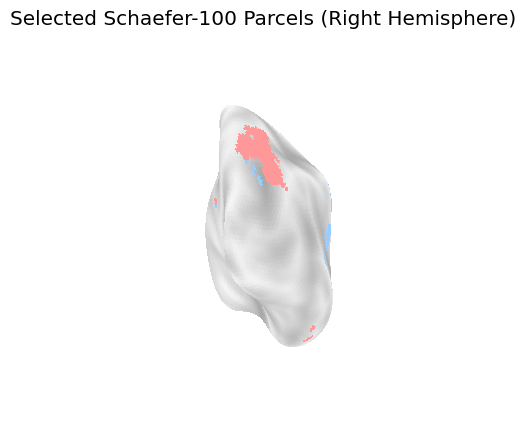

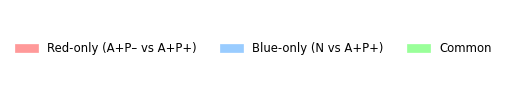

In [32]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from nilearn.datasets import fetch_surf_fsaverage, fetch_atlas_schaefer_2018
from nilearn.surface import vol_to_surf
from nilearn.plotting import plot_surf_roi

# ──────────────────────────────────────────────────────────
# 1) Fetch “fsaverage5” surface files for both hemispheres
#
#    This gives you file‐paths for pial, inflated, and sulcal meshes.
fs5 = fetch_surf_fsaverage(mesh="fsaverage5")
pial_right  = fs5["pial_right"]    # FreeSurfer‐format “.surf.gii” or “.pial” file
infl_right  = fs5["infl_right"]    # inflated surface for plotting
sulc_right  = fs5["sulc_right"]    # sulcal depth map (per‐vertex)

# ──────────────────────────────────────────────────────────
# 2) Fetch the 100-parcel, 7-network Schaefer atlas (1 mm resolution)
atlas = fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=1)
atlas_nii    = nib.load(atlas["maps"])    # NIfTI volume of labels (1..100)
atlas_labels = atlas["labels"]            # list of 100 human‐readable names

# ──────────────────────────────────────────────────────────
# 3) Define the parcel indices you want to highlight (zero-based)
#
#    Example from “A+P– vs A+P+” and “N vs A+P+”:
red_region  = [1, 15,  0, 22, 69,  2, 18, 23, 17, 28]   # “A+P– vs A+P+”
blue_region = [73, 34, 42, 28, 29, 74, 49, 33, 37, 17]  # “N vs A+P+”

red_set    = set(red_region)
blue_set   = set(blue_region)
common_set = red_set & blue_set
red_only   = sorted(red_set  - common_set)
blue_only  = sorted(blue_set - common_set)
common     = sorted(common_set)

# (Optional) Print out which region names these indices correspond to:
print("Red-only parcels:")
for idx in red_only:
    print(f"  • idx={idx:2d} → “{atlas_labels[idx]}”")
print("\nBlue-only parcels:")
for idx in blue_only:
    print(f"  • idx={idx:2d} → “{atlas_labels[idx]}”")
print("\nCommon parcels:")
for idx in common:
    print(f"  • idx={idx:2d} → “{atlas_labels[idx]}”")

# ──────────────────────────────────────────────────────────
# 4) Project the volumetric atlas labels onto the right-hemisphere pial mesh
#
#    vol_to_surf returns a 1D array of length = n_vertices_right,
#    where each entry is in {0,1,2,…,100}. 0 = no label; 1..100 = Schaefer parcel.
atlas_on_surf_right = vol_to_surf(
    atlas_nii,
    pial_right,
    interpolation="nearest"
)  # shape = (n_vertices_right,)

# ──────────────────────────────────────────────────────────
# 5) Build a per-vertex “overlay” integer map:
#      0 → background (hidden)
#      1 → vertices belonging to any “red_only” parcel
#      2 → vertices belonging to any “blue_only” parcel
#      3 → vertices belonging to any “common” parcel
labels_on_surf_right = np.zeros_like(atlas_on_surf_right, dtype=int)

# Note: atlas_on_surf_right is 1-based for parcel indices, whereas our lists are 0-based.
for idx in red_only:
    labels_on_surf_right[atlas_on_surf_right == (idx + 1)] = 1

for idx in blue_only:
    labels_on_surf_right[atlas_on_surf_right == (idx + 1)] = 2

for idx in common:
    labels_on_surf_right[atlas_on_surf_right == (idx + 1)] = 3

# ──────────────────────────────────────────────────────────
# 6) Create a pastel ListedColormap of length 4:
#      index 0 → transparent (we’ll hide it via threshold)
#      index 1 → pastel red
#      index 2 → pastel blue
#      index 3 → pastel green
cmap = ListedColormap([
    "#000000",   # idx=0, background (hidden)
    "#ff9999",   # idx=1 → “red_only”
    "#99ccff",   # idx=2 → “blue_only”
    "#99ff99"    # idx=3 → “common”
])

# ──────────────────────────────────────────────────────────
# 7) Plot the right hemisphere inflated surface with only those parcels colored
hemi   = "left"
engine = "matplotlib"   # or "plotly"

fig = plot_surf_roi(
    surf_mesh = infl_right,           # inflated mesh (file path or array)
    hemi      = hemi,
    roi_map   = labels_on_surf_right, # our per-vertex integer labels
    cmap      = cmap,
    bg_map    = sulc_right,           # sulcal depth for shading
    darkness  = 0.4,                  # adjust contrast of sulcal shading
    threshold = 0.5,                  # hides any vertex with label 0
    view      = "posterior",
    title     = "Selected Schaefer-100 Parcels (Right Hemisphere)"
)

if engine == "matplotlib":
    plt.show()
elif engine == "plotly":
    fig.show()

# ──────────────────────────────────────────────────────────
# 8) (Optional) Create a legend explaining colors → “1=red_only, 2=blue_only, 3=common”
import matplotlib.patches as mpatches

patches = [
    mpatches.Patch(color="#ff9999", label="Red-only (A+P– vs A+P+)"),
    mpatches.Patch(color="#99ccff", label="Blue-only (N vs A+P+)"),
    mpatches.Patch(color="#99ff99", label="Common")
]
plt.figure(figsize=(4, 1))
plt.legend(
    handles    = patches,
    loc        = "center",
    ncol       = 3,
    frameon    = False,
    fontsize   = "small"
)
plt.axis("off")
plt.show()
